In [1]:
import tensorflow as tf
from tensorflow import keras as keras
print(tf.__version__)

print(keras.__version__)

2.3.1
2.4.0


In [6]:
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Embedding, SimpleRNN, LSTM, Bidirectional
from tensorflow.keras.callbacks import History

# Modelowanie szeregów czasowych przy użyciu sieci rekurencyjnych

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

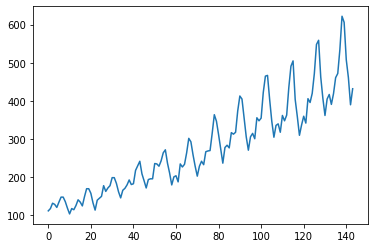

In [7]:
import pandas
import matplotlib.pyplot as plt
dataframe = pandas.read_csv('Dane/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
plt.plot(dataframe)
plt.show()

In [8]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

numpy.random.seed(7)

**LSTM Network for Regression**

We can phrase the problem as a regression problem.

That is, given the number of passengers (in units of thousands) this month, what is the number of passengers next month?

We can write a simple function to convert our single column of data into a two-column dataset: the first column containing this month’s (t) passenger count and the second column containing next month’s (t+1) passenger count, to be predicted.

In [9]:
dataset = dataframe.values
dataset = dataset.astype('float32')

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [10]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [11]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [12]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [13]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [14]:
trainX

array([[0.01544401, 0.02702703, 0.05405405],
       [0.02702703, 0.05405405, 0.04826255],
       [0.05405405, 0.04826255, 0.03281853],
       [0.04826255, 0.03281853, 0.05984557],
       [0.03281853, 0.05984557, 0.08494207],
       [0.05984557, 0.08494207, 0.08494207],
       [0.08494207, 0.08494207, 0.06177607],
       [0.08494207, 0.06177607, 0.02895753],
       [0.06177607, 0.02895753, 0.        ],
       [0.02895753, 0.        , 0.02702703],
       [0.        , 0.02702703, 0.02123553],
       [0.02702703, 0.02123553, 0.04247104],
       [0.02123553, 0.04247104, 0.07142857],
       [0.04247104, 0.07142857, 0.05984557],
       [0.07142857, 0.05984557, 0.04054055],
       [0.05984557, 0.04054055, 0.08687258],
       [0.04054055, 0.08687258, 0.12741312],
       [0.08687258, 0.12741312, 0.12741312],
       [0.12741312, 0.12741312, 0.10424709],
       [0.12741312, 0.10424709, 0.05598456],
       [0.10424709, 0.05598456, 0.01930502],
       [0.05598456, 0.01930502, 0.06949806],
       [0.

In [15]:
#reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [16]:
print(trainX.shape)
trainX

(92, 1, 3)


array([[[0.01544401, 0.02702703, 0.05405405]],

       [[0.02702703, 0.05405405, 0.04826255]],

       [[0.05405405, 0.04826255, 0.03281853]],

       [[0.04826255, 0.03281853, 0.05984557]],

       [[0.03281853, 0.05984557, 0.08494207]],

       [[0.05984557, 0.08494207, 0.08494207]],

       [[0.08494207, 0.08494207, 0.06177607]],

       [[0.08494207, 0.06177607, 0.02895753]],

       [[0.06177607, 0.02895753, 0.        ]],

       [[0.02895753, 0.        , 0.02702703]],

       [[0.        , 0.02702703, 0.02123553]],

       [[0.02702703, 0.02123553, 0.04247104]],

       [[0.02123553, 0.04247104, 0.07142857]],

       [[0.04247104, 0.07142857, 0.05984557]],

       [[0.07142857, 0.05984557, 0.04054055]],

       [[0.05984557, 0.04054055, 0.08687258]],

       [[0.04054055, 0.08687258, 0.12741312]],

       [[0.08687258, 0.12741312, 0.12741312]],

       [[0.12741312, 0.12741312, 0.10424709]],

       [[0.12741312, 0.10424709, 0.05598456]],

       [[0.10424709, 0.05598456, 0.01930

In [17]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, validation_split=0.1)

Epoch 1/100
82/82 [==============================] - 1s 17ms/step - loss: 0.0373 - val_loss: 0.1217
Epoch 2/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.0649
Epoch 3/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0095 - val_loss: 0.0469
Epoch 4/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0083 - val_loss: 0.0388
Epoch 5/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0072 - val_loss: 0.0323
Epoch 6/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.0256
Epoch 7/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0238
Epoch 8/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0194
Epoch 9/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0140
Epoch 10/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0134
Epoch 11

82/82 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0039
Epoch 84/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0042
Epoch 85/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0038
Epoch 86/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0039
Epoch 87/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0042
Epoch 88/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0039
Epoch 89/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 90/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 91/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0038
Epoch 92/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0039
Epoch 93/100


In [18]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.65 RMSE
Test Score: 55.22 RMSE


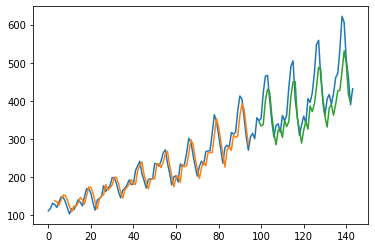

In [19]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()